In [1]:
import astropy
from scipy.optimize import minimize, curve_fit
from gaia_tools import query
import emcee
import corner
from scipy.interpolate import interp1d

from random import randint

import warnings
warnings.simplefilter("ignore")

import matplotlib.colors as mcolors

%pylab inline

Created TAP+ (v1.0.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: False
	Port: 80
	SSL Port: 443
Populating the interactive namespace from numpy and matplotlib


## Test Distances to which 1/parallax is accurate

In [2]:
q= '''SELECT parallax_error,parallax_over_error FROM gaiadr2.gaia_source
WHERE (1/parallax)*cos(RADIANS(b)) < 0.25
AND parallax>0
AND phot_g_mean_mag BETWEEN 16.5 AND 17 '''

In [4]:
out= query.query(q,local=False)
query.cache.nickname(q,'mag_check')

True

In [11]:
pe= out['parallax_error']

In [13]:
dist= 1/(median(pe)*5)
print(median(pe))
print('The furthest distance to which we can trust parallax as a measure of distance is: ',dist, 'kpc') 
print('Accounting for radius of the cylinder',sqrt(dist**2-0.25**2),'kpc')

0.09531313867704089
The furthest distance to which we can trust parallax as a measure of distance is:  2.098346594981833 kpc
Accounting for radius of the cylinder 2.083400689419069 kpc


## Calculate FWHM

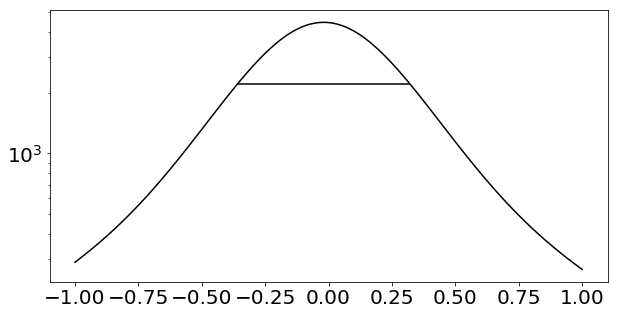

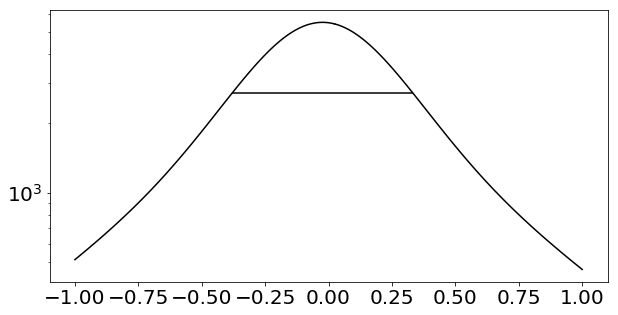

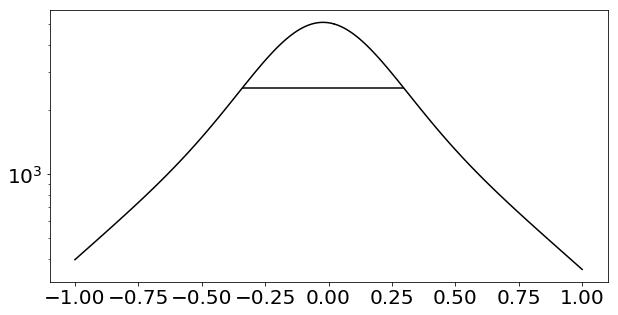

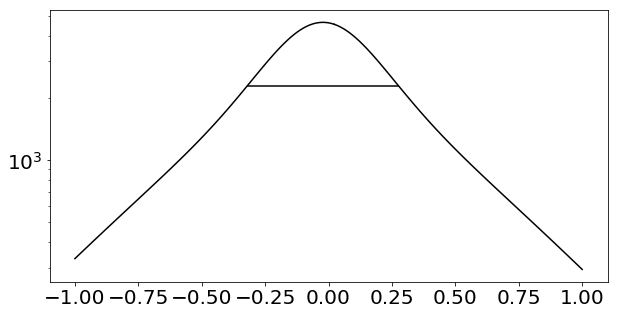

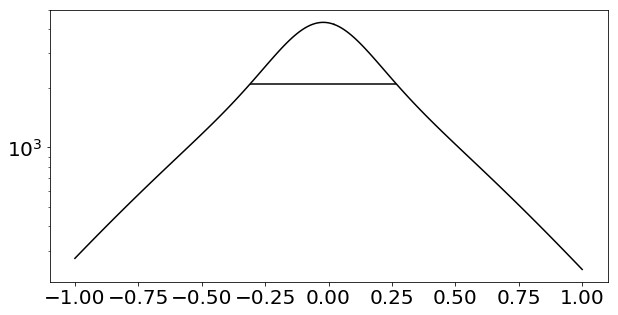

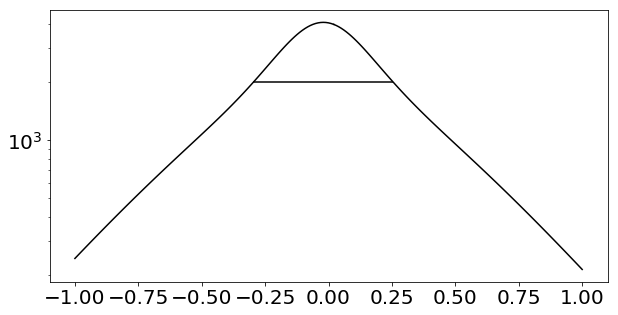

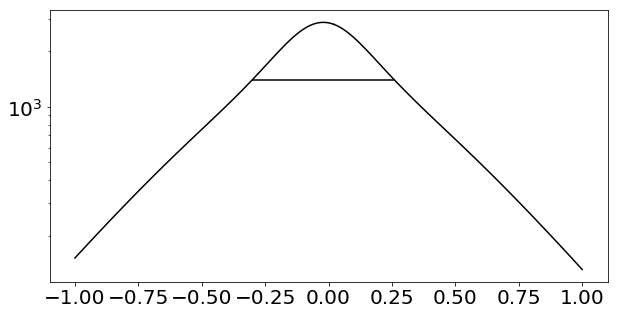

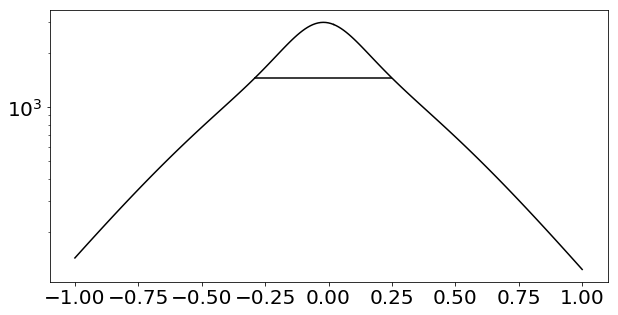

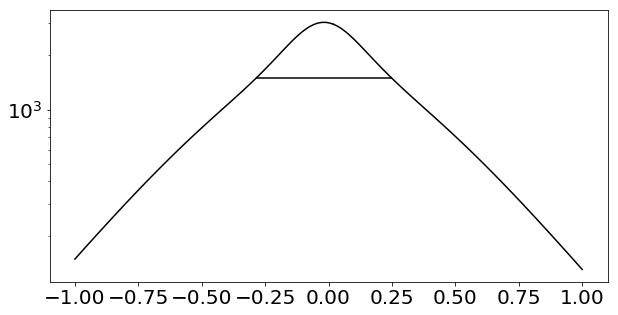

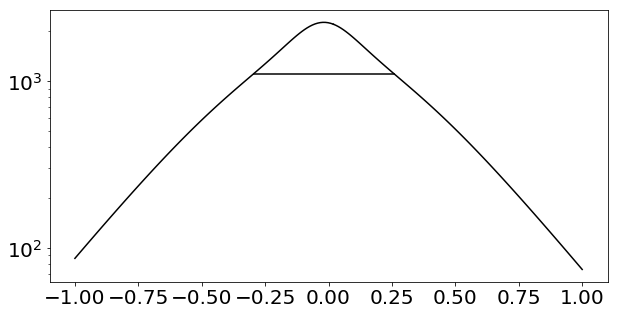

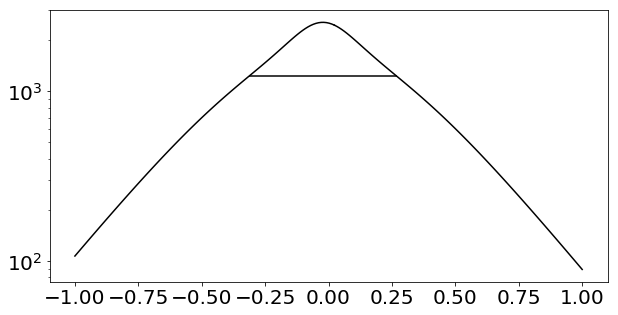

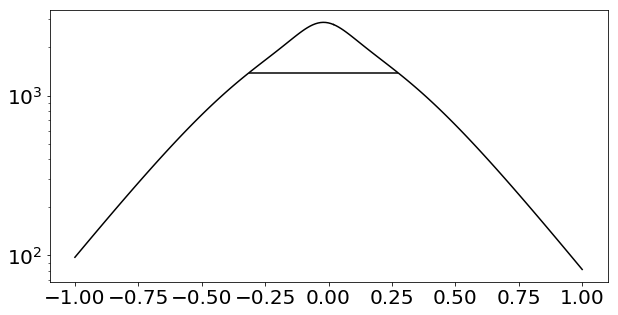

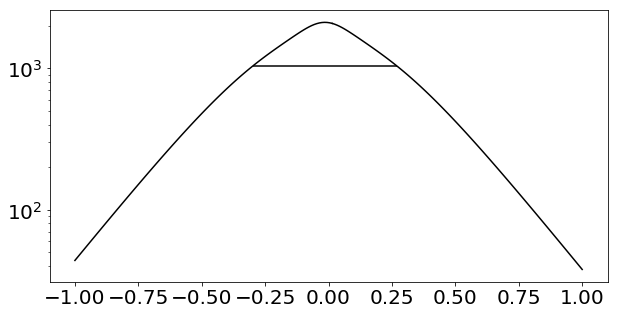

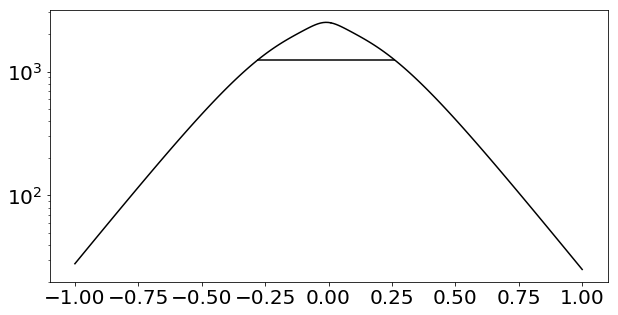

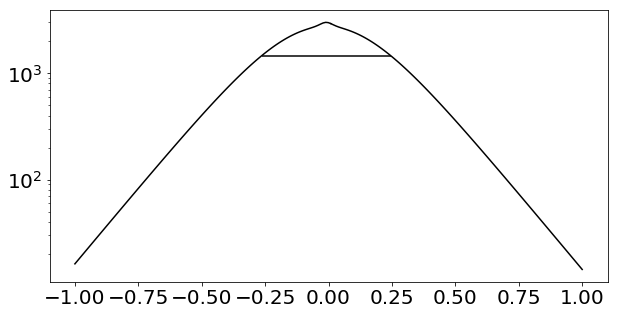

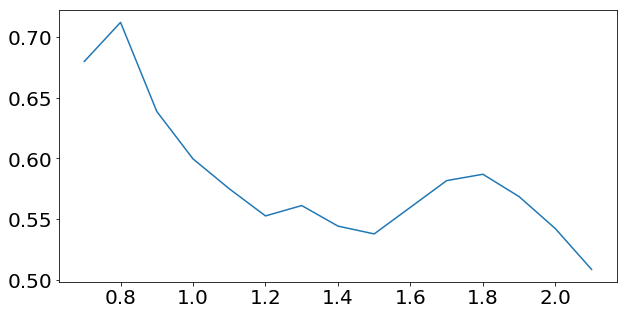

In [71]:
#Calculate FWHM
FWHM= empty(len(br_all))
bprp_x= empty(len(br_all))
for i,b in enumerate(br_all):
    z1= linspace(-1.,b.z0_mcmc[0],100)
    z2= linspace(b.z0_mcmc[0],1.,100)
    
    n1= b.n_model(b.psech_mcmc,z1)
    n2= b.n_model(b.psech_mcmc,z2)
    
    f1= interp1d(n1,z1)
    f2= interp1d(n2,z2)

    w1= f1(n1[-1]/2.)
    w2= f2(n2[0]/2.)
    
    FWHM[i]= w2-w1
    bprp_x[i]= b.br
    figure()
    semilogy(z1,n1,'k')
    semilogy(z2,n2,'k')
    hlines(n1[-1]/2.,w1,w2)
    
figure()
plot(bprp_x,FWHM)

## Plot multiple MCMC runs

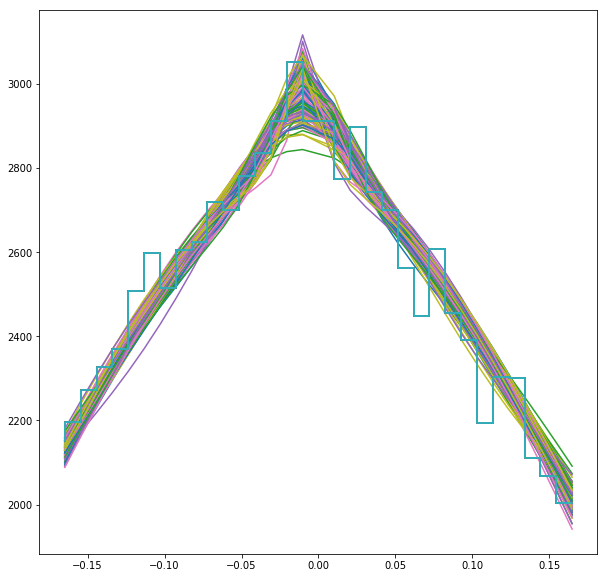

In [23]:
z= br_all[-1].zbin
i= random.randint(0,len(br_all[-1].sample),100)

for j in i:
    p= (br_all[-1].sample[j])
    p[0]= log10(p[0])
    mod= br_all[-1].n_model(p,z)

    plot(z,mod)
    step(z,br_all[-1].N)

## Some write up

The next step is to calculate the number count density binned in z. Since each slice in z has an equal volume and Gaia is supposed to be complete between magnitudes of 12 and 17, we do not need to account for a selection function. Again, the vertical lines demonstrate the location of future cuts on the data.

Next, we want to try and fit the data to a model. Specifically, a two-component model:
$$n(z_{obs})=n_0\left(sech^2\left(\frac{z_{obs}+z_\odot}{2H_1}\right)+f\,sech^2\left(\frac{z_{obs}+z_\odot}{2H_2}\right)\right)$$
Where $z_{obs}$ is the bins we choose for our z positions of stars, $n_0$ is simply a scaling factor, $z_\odot$ is the vertical position of the sun, $f$ describes the relative importance of each component, and finally $H_1$ and $H_2$ are roughly equivalent to scale heights of each component.

We choose an initial guess of $[n_0,z_\odot,H_1,f,H_2]$= [$2\times10^3$, 25 pc, 221 pc, 0.17, 582 pc] (Widrow, 2012).

Next, we want to fit the model using a maximum likelihood estimation. 
$$p(\theta\,|\,x) = \prod_i\frac{p(x_i\,|\,\theta)\,p(\theta)}{p(x_i)}$$
Where $\theta$ is the model and $x$ is the data. $p(x)$ is the probability that you got the data you did. This should be constant across models and therefore contributes to the maximum likelihood by equal amounts and can be ignored, $p(x)=1$. Next, recognize that the model parameters are independent, so we can write it as:
$$p(n_0,z_\odot,H_1,f,H_2\,|\,x) = p(x\,|\,n_0,z_\odot,H_1,f,H_2)\,p(n_0)\,p(z_\odot)\,p(H_1)\,p(f)\,p(H_2)$$
Since we are dealing with a number count statistic, we can use the poisson distribution to describe the probability of the model given the data. If we then also take the logarithm of the probability (since logarithm is an increasing function that's equivalent to maximizing the likelihood itself) we can write the logarithm of the probability as:
\begin{align}
\ln(p(\theta\,|\,x)) &= \sum_i\ln(p(x_i\,|\,\theta))+\ln(p(\theta))\\
&= \sum_i\left(\ln\left(e^{-\theta}\,\frac{\theta^{x_i}}{x_i!}\right)+\ln(p(\theta))\right)\\
&= \sum_i\left(-\theta+x_i\ln(\theta)-\ln(x_i!)+\ln(p(\theta))\right)\\
&= \sum_i\left(-\theta+x_i\ln(\theta)+\ln(p(\theta))\right)
\end{align}

## Widrow Asymmetry plot

This clearly resembles the plot from Widrow, et al., 2012.
![alt text](widrow12.png)
Fig. 2.— North-South asymmetry parameter A as a function of z. Top panel shows A(z) for
0.2 mag color bins: black square – r − i = {1.2 − 1.4}; red filled triangle – r − i = {1 − 1.2};
green open triangle – r − i = {0.8 − 1}; blue filled circle – r − i = {0.6 − 0.8}; magenta open
circle – r − i = {0.4 − 0.6}. Middle panel gives the average A for the color bins and z-range
used in Figure 1. Black points were generated using the photometric parallax relation from
Ivezi´c et al. (2008a). Bottom panel gives average A over the full range in z and r − i. Red
triangles assume $z_⊙$ = 39 pc instead of $z_⊙$ = 15 pc.

In [ ]:
This clearly resembles the plot from Widrow, et al., 2012.
![alt text](widrow12.png)
Fig. 2.— North-South asymmetry parameter A as a function of z. Top panel shows A(z) for
0.2 mag color bins: black square – r − i = {1.2 − 1.4}; red filled triangle – r − i = {1 − 1.2};
green open triangle – r − i = {0.8 − 1}; blue filled circle – r − i = {0.6 − 0.8}; magenta open
circle – r − i = {0.4 − 0.6}. Middle panel gives the average A for the color bins and z-range
used in Figure 1. Black points were generated using the photometric parallax relation from
Ivezi´c et al. (2008a). Bottom panel gives average A over the full range in z and r − i. Red
triangles assume $z_⊙$ = 39 pc instead of $z_⊙$ = 15 pc.